# Harmonizing `Response`s with JAX

In [1]:
from jax import jit
from gcdyn import responses, bdms, mutators, model
from jaxopt import GradientDescent, ScipyBoundedMinimize
from jax.tree_util import register_pytree_node_class
import matplotlib.pyplot as plt
import numpy as np
from ete3.coretype.tree import TreeError

responses.init_numpy(use_jax=True)

In [2]:
def plot_response(response):
    X = np.arange(-10, 10, 0.5)
    plt.plot(X, response.f(X))
    plt.ylabel("Birth rate")
    plt.show()

def evolve_trees(num_trees, init_x = 0, **evolve_kwargs):
    trees = []
    seed = evolve_kwargs.pop("seed", None)

    for _ in range(num_trees):
        while True:
            try:
                tree = bdms.TreeNode(x = init_x)
                tree.evolve(seed = seed, **evolve_kwargs)
                trees.append(tree)
                break

            except TreeError: # not enough survivors
                seed = seed + 1 if seed is not None else None

        seed = seed + 1 if seed is not None else None

    print("Average of", sum(len(list(tree.traverse())) for tree in trees) / len(trees), "nodes per tree, over", len(trees), "trees")

    return trees

## Understanding object flattening

In [3]:
resp = responses.ConstantResponse(-2.)
flat = resp.tree_flatten()

print(resp)
print(flat)
print(responses.ConstantResponse().tree_unflatten(flat[1], flat[0]))

ConstantResponse(value=-2.0)
((-2.0,), ('value',))
ConstantResponse(value=-2.0)


## Gradient descent

In [4]:
register_pytree_node_class(responses.ConstantResponse)

@jit
def objective(resp):
    x = resp.f(1)
    return (x - 5)**2

objective(resp)

DeviceArray(49., dtype=float32, weak_type=True)

In [5]:
optimizer = GradientDescent(fun=objective)
optimizer.run(
    responses.ConstantResponse(-2.)
)

OptStep(params=ConstantResponse(value=5.0), state=ProxGradState(iter_num=DeviceArray(1, dtype=int32, weak_type=True), stepsize=DeviceArray(1., dtype=float32, weak_type=True), error=DeviceArray(0., dtype=float32), aux=None, velocity=ConstantResponse(value=5.0), t=DeviceArray(1.618034, dtype=float32, weak_type=True)))

## Bounded optimization

Note that the bounds used in the optimizer call must be numerical and not `Response` objects, and I don't exactly know why

In [6]:
optimizer = ScipyBoundedMinimize(fun=objective)
optimizer.run(
    responses.ConstantResponse(-2.),
    (-10, 10)
)

OptStep(params=ConstantResponse(value=5.0), state=ScipyMinimizeInfo(fun_val=DeviceArray(0., dtype=float32, weak_type=True), success=True, status=0, iter_num=2))

## BDMS inference

In [7]:
birth_rate = responses.ConstantResponse(0.8)
death_rate = responses.ConstantResponse(1)
mutation_rate = responses.ConstantResponse(1)
sampling_probability = 1

mutator = mutators.GaussianMutator(-1, 1)

Average of 49.0 nodes per tree, over 5 trees

               /-11
              |
              |                  /- /-39
              |                 |
              |                 |         /-48
              |                 |      /-|
         /- /-|                 |     |  |         /-56
        |     |   /- /- /- /- /-|     |   \- /- /-|
        |     |  |              |   /-|            \-57
        |     |  |              |  |  |
        |     |  |              |  |  |      /- /-47
        |     |  |              |  |   \- /-|
        |     |  |               \-|        |   /- /-55
        |      \-|                 |         \-|
      /-|        |                 |            \-53
     |  |        |                 |
     |  |        |                  \- /-54
     |  |        |
     |  |        |   /-21
     |  |         \-|
     |  |            \-22
-- /-|  |
     |   \- /- /-10
     |
     |      /- /-35
     |   /-|
     |  |   \-26
     |  |
      \-|   /-13
    

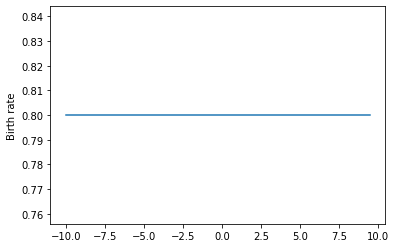

In [8]:
responses.init_numpy(False) # jax numpy breaks evolve for some reason

trees = evolve_trees(5, 
    t = 5,
    birth_rate = birth_rate,
    death_rate = death_rate,
    mutation_rate = mutation_rate,
    mutator = mutator,
    seed = 10
)

for tree in trees:
    tree.sample_survivors(p = sampling_probability, seed = 0)

print(trees[0])
plot_response(birth_rate)

In [9]:
responses.init_numpy(True)
mod = model.BdmsModel(
    trees = trees,
    death_rate = death_rate,
    mutation_rate = mutation_rate,
    mutator = mutator,
    sampling_probability = sampling_probability
)

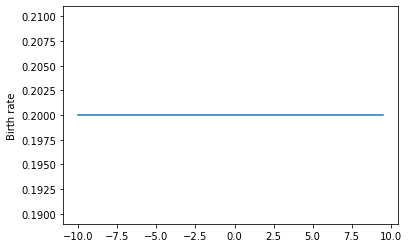

In [10]:
initial_birth_rate = responses.ConstantResponse(0.2)
plot_response(initial_birth_rate)

In [11]:
result = mod.fit(init_value=initial_birth_rate, lower_bounds=-np.inf, upper_bounds=np.inf)

result

OptStep(params=ConstantResponse(value=1.0352352857589722), state=ScipyMinimizeInfo(fun_val=DeviceArray(327.35458, dtype=float32, weak_type=True), success=True, status=0, iter_num=5))

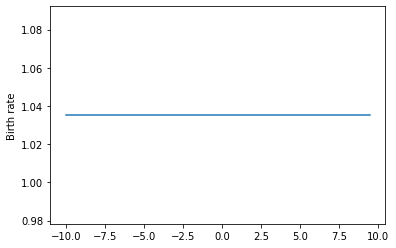

In [12]:
plot_response(result.params)

In [13]:
# JIT works, this runs faster
mod.fit(init_value=initial_birth_rate, lower_bounds=-np.inf, upper_bounds=np.inf)

OptStep(params=ConstantResponse(value=1.0352352857589722), state=ScipyMinimizeInfo(fun_val=DeviceArray(327.35458, dtype=float32, weak_type=True), success=True, status=0, iter_num=5))